In [1]:
#Importing libraries 
import os
import random
import numpy as np
import cv2
from matplotlib import pyplot as plt
from tensorflow.keras import  models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten, Dropout
import tensorflow as tf

In [74]:
#load the dataset
path_to_faces = os.path.join(os.getcwd(), 'data', 'olivetti', 'olivetti_faces.npy')
path_to_labels = os.path.join(os.getcwd(),'data', 'olivetti', 'olivetti_faces_target.npy')

In [75]:
# Function to generate image pairs
def generate_image_pairs(images, labels):
    # Generate index for each label
    unique_labels = np.unique(labels)
    label_wise_indices = dict()
    for label in unique_labels:
        label_wise_indices.setdefault(label,
                                      [index for index, curr_label in enumerate(labels) if
                                       label == curr_label])
    
    # Generate image pairs and labels
    pair_images = []
    pair_labels = []
    for index, image in enumerate(images):
        pos_indices = label_wise_indices.get(labels[index])
        pos_image = images[np.random.choice(pos_indices)]
        pair_images.append((image, pos_image))
        pair_labels.append(1)

        neg_indices = np.where(labels != labels[index])
        neg_image = images[np.random.choice(neg_indices[0])]
        pair_images.append((image, neg_image))
        pair_labels.append(0)
        
    return np.array(pair_images), np.array(pair_labels)

In [76]:
face_images = np.load(path_to_faces)
face_labels = np.load(path_to_labels)

In [77]:
target_shape = face_images[0].shape

In [78]:
from sklearn.utils import shuffle
images_dataset, labels_dataset = generate_image_pairs(face_images, face_labels)
images_dataset, labels_dataset = shuffle(images_dataset, labels_dataset)

In [79]:
np.array(images_dataset).shape

(800, 2, 64, 64)

In [80]:
print(f"Shape of inputs: {face_images.shape}")
print(f"Shape of labels: {face_labels.shape}")
print(f"Unique values for labels: {np.unique(face_labels)}")

Shape of inputs: (400, 64, 64)
Shape of labels: (400,)
Unique values for labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]


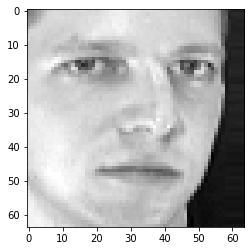

In [92]:
plt.imshow(face_images[1], cmap='gray')

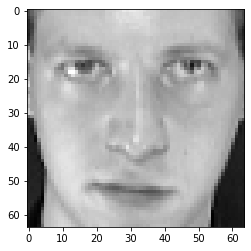

In [93]:
plt.imshow(face_images[2], cmap='gray')

In [10]:
face_images[0].max()

0.87603307

In [11]:
def make_embedding(): 
    inp = Input(shape=(64,64,1), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [12]:
embedding = make_embedding()

In [13]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 55, 55, 64)        6464      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 128)       401536    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         262272    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 128)         0 

In [3]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [15]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(64,64,1))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(64,64,1))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [16]:
siamese_model = make_siamese_model()

In [17]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         2247488     input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist (L1Dist)                (None, 4096)         0           embedding[0][0]     

In [18]:
siamese_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = siamese_model.fit([images_dataset[:, 0, :], images_dataset[:, 1, :]], labels_dataset, epochs=60, batch_size = 16)

Epoch 1/60
50/50 [==============================] - 174s 3s/step - loss: 0.6299 - accuracy: 0.5824
Epoch 2/60
50/50 [==============================] - 196s 4s/step - loss: 0.5637 - accuracy: 0.6254
Epoch 3/60
50/50 [==============================] - 178s 4s/step - loss: 0.5415 - accuracy: 0.6792
Epoch 4/60
50/50 [==============================] - 176s 4s/step - loss: 0.5111 - accuracy: 0.6809
Epoch 5/60
50/50 [==============================] - 192s 4s/step - loss: 0.4929 - accuracy: 0.7241
Epoch 6/60
50/50 [==============================] - 198s 4s/step - loss: 0.4916 - accuracy: 0.7505
Epoch 7/60
50/50 [==============================] - 179s 4s/step - loss: 0.4708 - accuracy: 0.7783
Epoch 8/60
50/50 [==============================] - 181s 4s/step - loss: 0.4914 - accuracy: 0.7945
Epoch 9/60
50/50 [==============================] - 198s 4s/step - loss: 0.4385 - accuracy: 0.8401
Epoch 10/60
50/50 [==============================] - 175s 4s/step - loss: 0.4321 - accuracy: 0.8434
Epoch 11/

In [19]:
siamese_model.save('siammodelOlivett.h5')

In [26]:
# Reload model 
siamese_model = tf.keras.models.load_model('siammodelOlivett.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [51]:
path_to_anchor = os.path.join(os.getcwd(), 'data', 'anchor')
path_to_positive = os.path.join(os.getcwd(),'data', 'positive')
path_to_negative = os.path.join(os.getcwd(),'data', 'negative')

In [76]:
path_to_folder = os.path.join(os.getcwd(), 'data', 'Vitya')

In [77]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
num_of_photo = 1
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(path_to_folder, 'Vitya{}.jpg'.format(num_of_photo))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    num_of_photo += 1
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show fraйme
cv2.destroyAllWindows()

In [27]:
path_to_negative = os.path.join(os.getcwd(),'data', 'negative')
tanya_anchor = tf.data.Dataset.list_files(os.path.join(os.getcwd(), 'data', 'Tanya')+'\*.jpg').take(20)
tanya_positive = tf.data.Dataset.list_files(os.path.join(os.getcwd(), 'data', 'Tanya')+'\*.jpg').take(20)
negative = tf.data.Dataset.list_files(path_to_negative+'\*.jpg').take(20)

In [28]:
dir_test = tanya_anchor.as_numpy_iterator()
dir_testbn = tanya_positive.as_numpy_iterator()

In [29]:
print(dir_test.next())
print(dir_testbn.next())

b'c:\\Diploma\\data\\Tanya\\Tanya3821.jpg'
b'c:\\Diploma\\data\\Tanya\\Tanya3517.jpg'


In [30]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (64,64))
    img = tf.image.rgb_to_grayscale(img)
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [31]:
positives = tf.data.Dataset.zip((tanya_anchor, tanya_positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(tanya_anchor)))))
negatives = tf.data.Dataset.zip((tanya_anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(tanya_anchor)))))
data = positives.concatenate(negatives)

In [32]:
len(data)

40

In [33]:
samples = data.as_numpy_iterator()
exampple = samples.next()
exampple

(b'c:\\Diploma\\data\\Tanya\\Tanya3478.jpg',
 b'c:\\Diploma\\data\\Tanya\\Tanya3743.jpg',
 1.0)

In [34]:
exampple = samples.next()
exampple

(b'c:\\Diploma\\data\\Tanya\\face22.jpg',
 b'c:\\Diploma\\data\\Tanya\\face22.jpg',
 1.0)

In [35]:
people = ['Tina', 'Serg', 'Margo', 'Vova', 'bloger_1', 'bloger_2', 'Danylo', 'Svyat','Tanegina', 'Daria','Helena','Kreed', 'Julia', 'Andrew',
          'bloger_3','bloger_4','bloger_5','bloger_6', 'bloger_7','bloger_8']
#people = ['Tina', 'Serg', 'Vova', 'Vitya', 'bloger_2']
for i in people:
    local_path = os.path.join(os.getcwd(), 'data', i)

    anchor = tf.data.Dataset.list_files(os.path.join(local_path+'\*.jpg')).take(20)
    positive = tf.data.Dataset.list_files(os.path.join(local_path+'\*.jpg')).take(20)
    negative = tf.data.Dataset.list_files(path_to_negative+'\*.jpg').take(20)

    positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
    negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
    
    data = data.concatenate(positives)
    data = data.concatenate(negatives)
    
    print(i)

Tina
Serg
Margo
Vova
bloger_1
bloger_2
Danylo
Svyat
Tanegina
Daria
Helena
Kreed
Julia
Andrew
bloger_3
bloger_4
bloger_5
bloger_6
bloger_7
bloger_8


In [36]:
len(data)

812

In [37]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [38]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [39]:
# Training partition
train_data = data.take(round(len(data)*.7))

# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))


In [40]:
images_anc, images_val, labels = tuple(zip(*train_data))

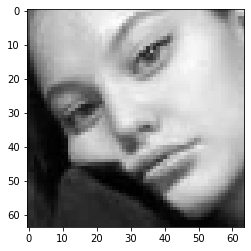

In [89]:
plt.imshow(np.array(images_anc)[4],cmap='gray')

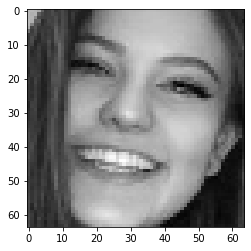

In [90]:
plt.imshow(np.array(images_val)[4], cmap='gray')

In [91]:
np.array(labels)[4]

1.0

In [44]:
#siamese_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = siamese_model.fit([np.array(images_anc), np.array(images_val)], np.array(labels), epochs=30, batch_size = 32)

Epoch 1/30
18/18 [==============================] - 126s 7s/step - loss: 1.2518 - accuracy: 0.5299
Epoch 2/30
18/18 [==============================] - 122s 7s/step - loss: 0.8465 - accuracy: 0.5194
Epoch 3/30
18/18 [==============================] - 123s 7s/step - loss: 0.8509 - accuracy: 0.5563
Epoch 4/30
18/18 [==============================] - 125s 7s/step - loss: 0.7588 - accuracy: 0.5951
Epoch 5/30
18/18 [==============================] - 123s 7s/step - loss: 0.7518 - accuracy: 0.5915
Epoch 6/30
18/18 [==============================] - 122s 7s/step - loss: 0.6962 - accuracy: 0.6144
Epoch 7/30
18/18 [==============================] - 125s 7s/step - loss: 0.6881 - accuracy: 0.6338
Epoch 8/30
18/18 [==============================] - 123s 7s/step - loss: 0.6904 - accuracy: 0.6356
Epoch 9/30
18/18 [==============================] - 124s 7s/step - loss: 0.6907 - accuracy: 0.6250
Epoch 10/30
18/18 [==============================] - 123s 7s/step - loss: 0.6279 - accuracy: 0.6743
Epoch 11/

In [54]:
history = siamese_model.fit([np.array(images_anc), np.array(images_val)], np.array(labels), epochs=20, batch_size = 32)

Epoch 1/20
18/18 [==============================] - 138s 8s/step - loss: 0.3572 - accuracy: 0.8662
Epoch 2/20
18/18 [==============================] - 135s 8s/step - loss: 0.3395 - accuracy: 0.8662
Epoch 3/20
18/18 [==============================] - 136s 8s/step - loss: 0.3726 - accuracy: 0.8539
Epoch 4/20
18/18 [==============================] - 134s 7s/step - loss: 0.3746 - accuracy: 0.8521
Epoch 5/20
18/18 [==============================] - 135s 7s/step - loss: 0.3351 - accuracy: 0.8838
Epoch 6/20
18/18 [==============================] - 134s 7s/step - loss: 0.3171 - accuracy: 0.9032
Epoch 7/20
18/18 [==============================] - 133s 7s/step - loss: 0.2948 - accuracy: 0.9120
Epoch 8/20
18/18 [==============================] - 132s 7s/step - loss: 0.3468 - accuracy: 0.8785
Epoch 9/20
18/18 [==============================] - 132s 7s/step - loss: 0.3274 - accuracy: 0.8732
Epoch 10/20
18/18 [==============================] - 136s 8s/step - loss: 0.2952 - accuracy: 0.9014
Epoch 11/

In [64]:
history = siamese_model.fit([np.array(images_anc), np.array(images_val)], np.array(labels), epochs=20, batch_size = 32)

Epoch 1/20
18/18 [==============================] - 288s 16s/step - loss: 0.2541 - accuracy: 0.9261
Epoch 2/20
18/18 [==============================] - 290s 16s/step - loss: 0.2189 - accuracy: 0.9525
Epoch 3/20
18/18 [==============================] - 281s 16s/step - loss: 0.2076 - accuracy: 0.9384
Epoch 4/20
18/18 [==============================] - 253s 14s/step - loss: 0.1969 - accuracy: 0.9595
Epoch 5/20
18/18 [==============================] - 293s 16s/step - loss: 0.2289 - accuracy: 0.9384
Epoch 6/20
18/18 [==============================] - 298s 16s/step - loss: 0.1825 - accuracy: 0.9683
Epoch 7/20
18/18 [==============================] - 270s 15s/step - loss: 0.1692 - accuracy: 0.9718
Epoch 8/20
18/18 [==============================] - 340s 19s/step - loss: 0.1823 - accuracy: 0.9648
Epoch 9/20
18/18 [==============================] - 372s 21s/step - loss: 0.1930 - accuracy: 0.9525
Epoch 10/20
18/18 [==============================] - 383s 21s/step - loss: 0.1775 - accuracy: 0.9577

In [72]:
siamese_model.save('simmodelvar1.h5')

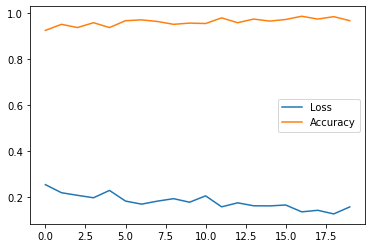

In [65]:
# Training Plot
plt.plot(history.history["loss"])
plt.plot(history.history["accuracy"])
plt.legend(["Loss","Accuracy"])

In [4]:
# Reload model 
siamese_model = tf.keras.models.load_model('siammodelOlivett.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [ ]:
tanya_anchor = tf.data.Dataset.list_files(os.path.join(os.getcwd(), 'data', 'Tanya')+'\*.jpg').take(20)
tanya_positive = tf.data.Dataset.list_files(os.path.join(os.getcwd(), 'data', 'Tanya')+'\*.jpg').take(20)

In [66]:
test_input, test_val, y_true = tuple(zip(*test_data))
y_hat = siamese_model.predict([np.array(test_input), np.array(test_val)])


In [ ]:
y_hat = siamese_model.predict([np.array(test_input), np.array(test_val)])

In [67]:
y_hat

array([[9.56091285e-03],
       [4.51403260e-02],
       [8.11563611e-01],
       [8.64357948e-01],
       [1.86801910e-01],
       [6.09049797e-02],
       [3.34970355e-02],
       [8.89290929e-01],
       [4.84365225e-03],
       [7.77730227e-01],
       [9.73649919e-02],
       [8.83080244e-01],
       [6.68641627e-02],
       [7.96645224e-01],
       [2.64553726e-01],
       [3.14684330e-05],
       [1.70864463e-02],
       [2.44670689e-01],
       [8.93401980e-01],
       [8.71732235e-01],
       [9.02131379e-01],
       [7.97217488e-01],
       [8.33100557e-01],
       [1.95074081e-03],
       [3.45826298e-01],
       [1.22918576e-01],
       [3.84495884e-01],
       [2.57596374e-03],
       [8.28658104e-01],
       [9.01691794e-01],
       [6.48776549e-05],
       [8.86257291e-01],
       [1.24479473e-01],
       [4.29689288e-02],
       [4.43041325e-04],
       [4.02864814e-03],
       [8.94822240e-01],
       [9.21682537e-01],
       [8.40480089e-01],
       [9.76079702e-03],


In [68]:
# Post processing the results 
a = np.array([1 if prediction > 0.5 else 0 for prediction in y_hat ])

In [69]:
b = np.array(y_true).astype(np.int)

In [70]:
#accuracy for test
sum(a == b) / len(a)

0.8565573770491803

In [71]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall, Accuracy
r = Recall()
p = Precision()
a = Accuracy()

yhat = siamese_model.predict([np.array(test_input), np.array(test_val)])
r.update_state(y_true, yhat)
p.update_state(y_true,yhat) 
a.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy(), a.result().numpy())

0.83064514 0.8803419 0.0
